In [27]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")

import pysftp
import datetime 
import zipfile
import nadiautil

uri = "freenas"
username = "rt"
password = "hydrogen1420"
data_dir = '/mnt/NAS/rtdata/'
local_dir = 'dat/'

serial = "000000000c59f97b"
start_time = datetime.datetime(2018, 3, 16, 0, 0)
end_time = datetime.datetime(2018, 3, 17, 0, 0)

files = None
batch_ids = []

cnopts = pysftp.CnOpts()
cnopts.hostkeys = None   

with pysftp.Connection(uri, username=username, password=password, cnopts=cnopts) as sftp:
    with sftp.cd(data_dir):
        files = sftp.listdir()
        for file in files:
            
            this_serial, this_time = file.split('.zip')[0].split('_')
            this_time = datetime.datetime.strptime(this_time, "%Y-%m-%d-%H-%M-%S.%f")
            if (this_serial == serial and 
                this_time > start_time and 
                this_time < end_time):
                print(file)
                batch_ids.append(file.split('.zip')[0])
                sftp.get(file, local_dir+file, preserve_mtime=True)
                zip_ref = zipfile.ZipFile(local_dir+file, 'r')
                zip_ref.extractall(local_dir+file.split('.zip')[0])
                zip_ref.close()



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
000000000c59f97b_2018-03-16-00-17-18.869676.zip


c:\users\carit\documents\projects\nadia\env\lib\site-packages\pysftp\__init__.py:61: UserWarning: Failed to load HostKeys from C:\Users\carit\.ssh\known_hosts.  You will need to explicitly load HostKeys (cnopts.hostkeys.load(filename)) or disableHostKey checking (cnopts.hostkeys = None).
  warnings.warn(wmsg, UserWarning)


000000000c59f97b_2018-03-16-06-51-06.532400.zip
000000000c59f97b_2018-03-16-06-56-12.492993.zip
000000000c59f97b_2018-03-16-07-01-19.852142.zip
000000000c59f97b_2018-03-16-07-06-30.872579.zip
000000000c59f97b_2018-03-16-07-11-42.903582.zip
000000000c59f97b_2018-03-16-07-16-53.390080.zip
000000000c59f97b_2018-03-16-07-21-59.962519.zip
000000000c59f97b_2018-03-16-07-27-05.287565.zip
000000000c59f97b_2018-03-16-07-32-22.501312.zip
000000000c59f97b_2018-03-16-07-37-26.963364.zip
000000000c59f97b_2018-03-16-07-42-30.332559.zip
000000000c59f97b_2018-03-16-07-47-41.652175.zip
000000000c59f97b_2018-03-16-07-52-48.930646.zip
000000000c59f97b_2018-03-16-07-58-07.113997.zip
000000000c59f97b_2018-03-16-08-03-24.236993.zip
000000000c59f97b_2018-03-16-08-08-34.295743.zip
000000000c59f97b_2018-03-16-08-13-44.742711.zip
000000000c59f97b_2018-03-16-08-19-02.971873.zip
000000000c59f97b_2018-03-16-08-24-08.362188.zip
000000000c59f97b_2018-03-16-08-29-25.833024.zip
000000000c59f97b_2018-03-16-08-34-32.327

In [29]:
import pathlib
import numpy as np
import yaml
import scipy.signal as signal
import locale



interval_count = nadiautil.getIntervals('dat')

fft_bins = 2**16
results = np.empty([interval_count,fft_bins])
times = np.empty([interval_count])
freqs = np.empty([fft_bins])

i = 0

for batch in batch_ids:
    print(batch)
    this_serial, this_time = file.split('.zip')[0].split('_')
    this_time = datetime.datetime.strptime(this_time, "%Y-%m-%d-%H-%M-%S.%f")
    
    path = pathlib.Path(local_dir + batch)
    params = yaml.load(open(path.joinpath('params.yaml')))
    sample_rate = int(float(params['sample_rate_hz']))
    intervals = None
    with open(path.joinpath('intervals')) as f:
        intervals = [str(line).strip() for line in f]
        for interval in intervals:
            #print(path.joinpath(interval+'_blank.npz'))
            r = np.load(path.joinpath(interval+'_blank.npz'))['arr_0']
            _, blank_tmp = signal.welch(r, fs=sample_rate, return_onesided=False, nperseg=fft_bins)
            
            r = np.load(path.joinpath(interval+'.npz'))['arr_0']
            freqs_tmp, scratch_tmp = signal.welch(r, fs=sample_rate, return_onesided=False, nperseg=fft_bins)

            
            freqs = np.fft.fftshift(freqs_tmp)
            times[i]=((this_time-datetime.datetime(2012, 1, 1))+datetime.timedelta(seconds=float(interval))).total_seconds()
            results[i]=np.fft.fftshift((scratch_tmp-blank_tmp)/blank_tmp)

            i = i + 1
            

means = np.mean(results, axis=0)    

#results[results == 1] = 0
#results[results < 0] = 0
#results[results == 0] = np.amin(results[np.nonzero(results)])

000000000c59f97b_2018-03-16-00-17-18.869676
000000000c59f97b_2018-03-16-06-51-06.532400
000000000c59f97b_2018-03-16-06-56-12.492993
000000000c59f97b_2018-03-16-07-01-19.852142
000000000c59f97b_2018-03-16-07-06-30.872579
000000000c59f97b_2018-03-16-07-11-42.903582
000000000c59f97b_2018-03-16-07-16-53.390080
000000000c59f97b_2018-03-16-07-21-59.962519
000000000c59f97b_2018-03-16-07-27-05.287565
000000000c59f97b_2018-03-16-07-32-22.501312
000000000c59f97b_2018-03-16-07-37-26.963364
000000000c59f97b_2018-03-16-07-42-30.332559
000000000c59f97b_2018-03-16-07-47-41.652175
000000000c59f97b_2018-03-16-07-52-48.930646
000000000c59f97b_2018-03-16-07-58-07.113997
000000000c59f97b_2018-03-16-08-03-24.236993
000000000c59f97b_2018-03-16-08-08-34.295743
000000000c59f97b_2018-03-16-08-13-44.742711
000000000c59f97b_2018-03-16-08-19-02.971873
000000000c59f97b_2018-03-16-08-24-08.362188
000000000c59f97b_2018-03-16-08-29-25.833024
000000000c59f97b_2018-03-16-08-34-32.327103
000000000c59f97b_2018-03-16-08-3

In [30]:


print(batch_ids)
print(freqs.shape)
print(results.shape)
print(times.shape)
print(results)



['000000000c59f97b_2018-03-16-00-17-18.869676', '000000000c59f97b_2018-03-16-06-51-06.532400', '000000000c59f97b_2018-03-16-06-56-12.492993', '000000000c59f97b_2018-03-16-07-01-19.852142', '000000000c59f97b_2018-03-16-07-06-30.872579', '000000000c59f97b_2018-03-16-07-11-42.903582', '000000000c59f97b_2018-03-16-07-16-53.390080', '000000000c59f97b_2018-03-16-07-21-59.962519', '000000000c59f97b_2018-03-16-07-27-05.287565', '000000000c59f97b_2018-03-16-07-32-22.501312', '000000000c59f97b_2018-03-16-07-37-26.963364', '000000000c59f97b_2018-03-16-07-42-30.332559', '000000000c59f97b_2018-03-16-07-47-41.652175', '000000000c59f97b_2018-03-16-07-52-48.930646', '000000000c59f97b_2018-03-16-07-58-07.113997', '000000000c59f97b_2018-03-16-08-03-24.236993', '000000000c59f97b_2018-03-16-08-08-34.295743', '000000000c59f97b_2018-03-16-08-13-44.742711', '000000000c59f97b_2018-03-16-08-19-02.971873', '000000000c59f97b_2018-03-16-08-24-08.362188', '000000000c59f97b_2018-03-16-08-29-25.833024', '000000000c5

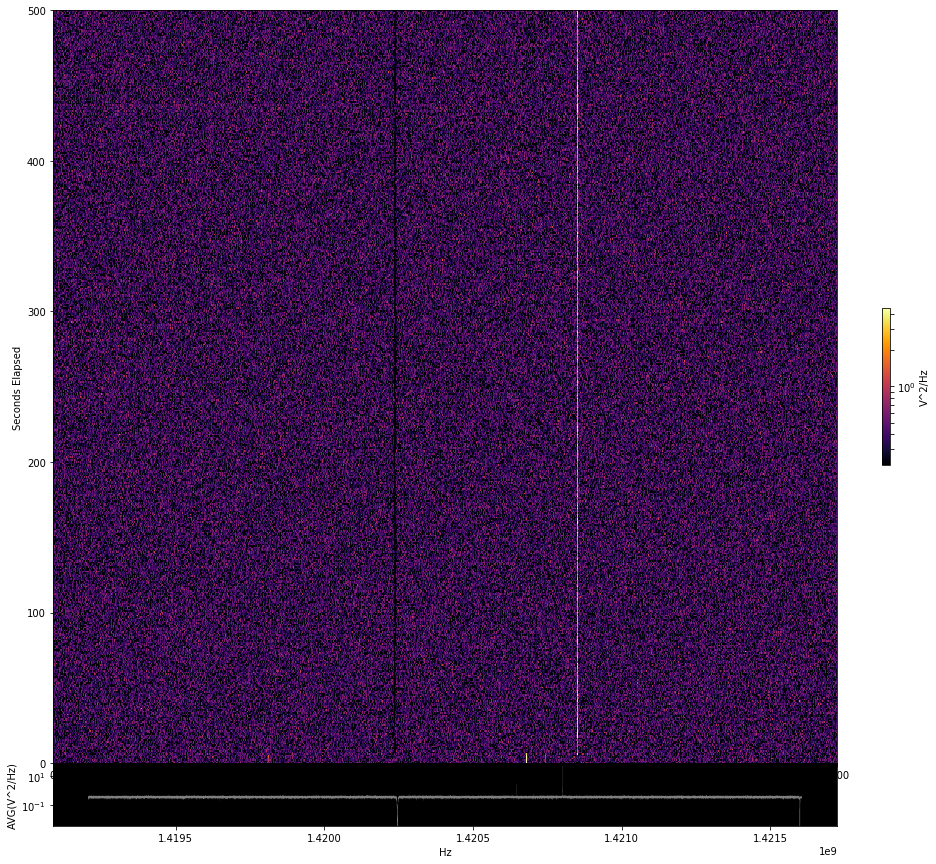

In [35]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize

def rebin(arr, new_shape):
    """Rebin 2D array arr to shape new_shape by averaging."""
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)

rows=500
cols=1000

processed_results = rebin(results[:(results.shape[0] // rows) * rows,:(results.shape[1] // cols) * cols], 
                          (rows,cols))
processed_results[processed_results == 1] = 0
processed_results[processed_results < 0] = 0
processed_results[processed_results == 0] = np.amin(processed_results[np.nonzero(processed_results)])

freq = params['center_freq_hz']
bw = params['bandwidth_hz']

min_freq = np.amin(freqs)+freq
max_freq = np.amax(freqs)+freq

# , figsize=(20,30)
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,15), gridspec_kw = 
                     {'height_ratios':[12, 1], 'width_ratios':[15, 1]})
f.subplots_adjust(hspace=0, wspace=0)
#ax[0][0].set_xlim(min_freq, max_freq)
#ax[0][0].set_ylim(np.min(times), np.max(times))
waterfall = ax[0][0].pcolormesh(processed_results, cmap='inferno',
             norm=LogNorm(np.amax(processed_results)/100,np.amax(processed_results)/5), 
            )


ax[0][0].set_ylabel("Seconds Elapsed")

#ax[1][0].set_xlim(min_freq, max_freq)

ax[1][0].set_facecolor('k')
ax[1][0].plot(freqs+freq, means, color='w', alpha=0.5, linewidth=0.1)
ax[1][0].set_yscale('log')
ax[1][0].set_ylabel("AVG(V^2/Hz)")
ax[1][0].set_xlabel("Hz")

cbar = f.colorbar(waterfall, ax=ax[0][1])
cbar.set_label('V^2/Hz')
ax[0][1].set_axis_off()
ax[1][1].set_axis_off()
ax[0][1].set_ylabel('V^2/Hz', rotation=270)

plt.show()


(911,)
(100, 2000)


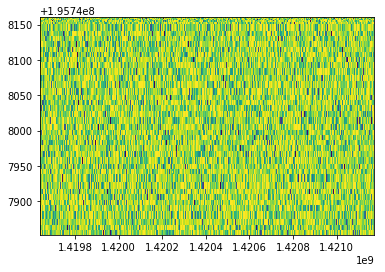

In [107]:
fig, ax = plt.subplots(1)
print(times.shape)
print(processed_results.shape)
p = ax.pcolormesh(freqs+freq, times, results, norm=LogNorm(np.mean(processed_results)/100, np.amax(processed_results)/2))
plt.show()

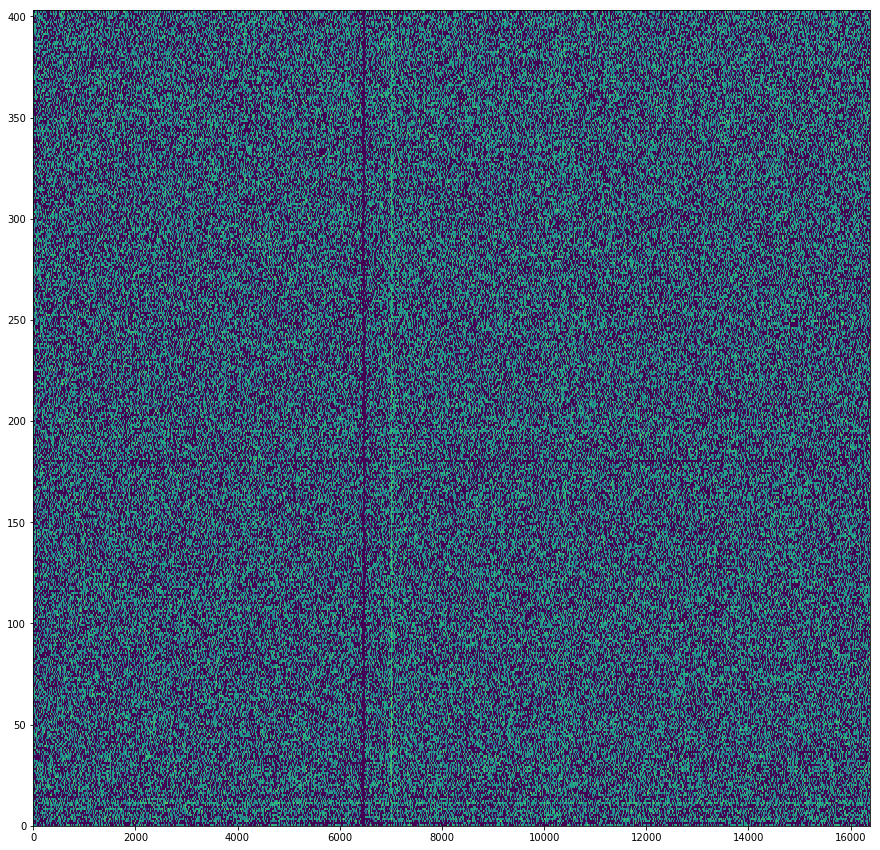

In [49]:
fig, ax = plt.subplots(1,figsize=(15,15))

p = ax.pcolormesh(processed_results, norm=LogNorm(np.mean(processed_results)/100, np.amax(processed_results)))
plt.show()